In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import softmax
import random
import pickle
from datetime import datetime
from collections import Counter

from tqdm import tqdm

import gym
from gym.spaces import Discrete, Tuple

from env_mp_simple import MetaGamesTheOne
from rmax_1_batch_TheOne import RmaxAgent, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return np.round(np.divide(number, radius)) * radius

def Boltzmann(arr):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    action_value = np.zeros(arr.shape[0])
    prob = softmax(arr/0.4, 1)
    for b in range(arr.shape[0]):
        action_value[b] = np.random.choice(np.arange(arr.shape[1]), p=prob[b])
    return np.reshape(action_value, (bs))

In [ ]:
bs = 2
inner_gamma = 0         #inner game discount factor, 0 since it's a one shot game
meta_gamma = 0.8          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 1
rmax_error = 0.5
meta_epi = 10000

step=0.01              #distance between each interval for inner game
epsilon = 0

In [ ]:
#reward tensor for plotting purposes [bs, episode, step, agents]
plot_rew = np.zeros((bs, meta_epi, 2))

# creating environment
env = MetaGamesTheOne(bs, step)

# creating rmax agent
memory = Memory()
rmax = RmaxAgent(R_max, bs, meta_gamma, inner_gamma, step, epsilon, rmax_error)

In [ ]:
for episode in tqdm(range(meta_epi)): #for each meta-episode
    #reset environment 
    #initialise meta-state and meta-action randomly
    meta_s = env.reset()
    done = env.done
    memory.states.append(meta_s)
   
    while any(done)==0:     #while any batches still arent "done" with the game
        print(done)
        #--------------------------------------START OF INNER GAME--------------------------------------  
        #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
        our_action = np.argmax(rmax.Q[np.arange(bs), rmax.find_meta_index(meta_s, "s").astype(int), :], axis=1)

        #print("inner actions: ", our_action, oppo_action)
        #run inner game according to actions
        obs, reward, info, done = env.step(our_action)  

        #update inner r matrix [agent, action]
        our_innerr = np.transpose(np.stack([our_action, 1-our_action]) * reward)
        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting        
        np.append(plot_rew[:,0,0], reward.squeeze())
        np.append(plot_rew[:,0,1], info.squeeze())

        #meta-action = action that corresponds to max Q(meta_s) = our inner Q
        meta_a = our_action
        memory.actions.append(meta_a) 

        #meta-state = discretized inner game Q table of all agents
        new_meta_s = obs
        memory.states.append(new_meta_s)    

        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward               
        memory.rewards.append(our_REW)

        #rmax update step
        rmax.update(memory, meta_s, meta_a, new_meta_s)

        #prepare meta_s for next step
        meta_s = new_meta_s


In [ ]:
# Open a file and use dump()
with open('plot_rew' + str(datetime.now()) + '.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(plot_rew, file)

# Open a file and use dump()
with open('rmax_nSA' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(rmax.nSA, file)

# Plots

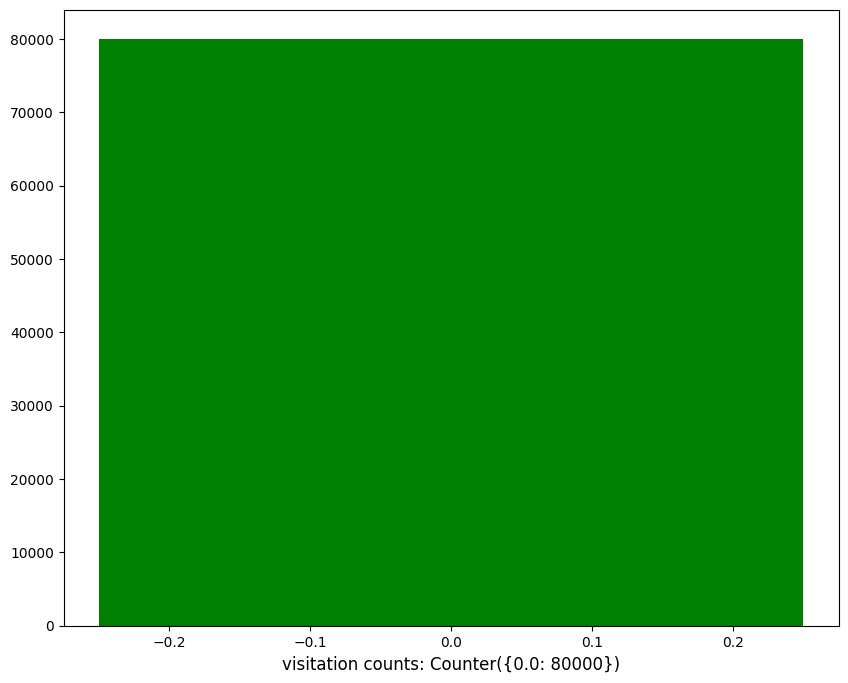

In [5]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA[0].flatten().tolist())):
    visit_dict[i]= rmax.nSA[0].flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
plt.savefig('histogram at' + str(datetime.now()) + '.png')

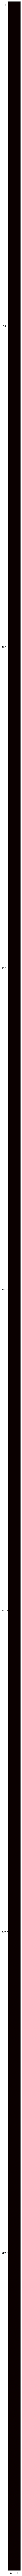

In [7]:
#generate heatmap
plt.imshow(rmax.nSA[0], cmap='hot', interpolation='nearest')
figure1 = plt.gcf()
figure1.set_size_inches(50, 200)
#plt.savefig('heatmap for' + str(datetime.now()) + '.png')

In [5]:
# #checks the unvisited states
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
# rmax.nSA[0]
# arr=[]
# for i in range(560):
#     if all(rmax.nSA[0,i])==0:
#         arr.append(i)
#         print(i)
        
# haha = len(arr)
# Q_size = 4
# reconstruct = np.zeros((haha, Q_size))
# index=arr
# divv = [280,140,70,1]
# for i in range(Q_size-1):
#     qi, modi = np.divmod(index, divv[i])
#     reconstruct[:, i] = qi*radius
#     index=modi
# reconstruct[:,3] = modi     

106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


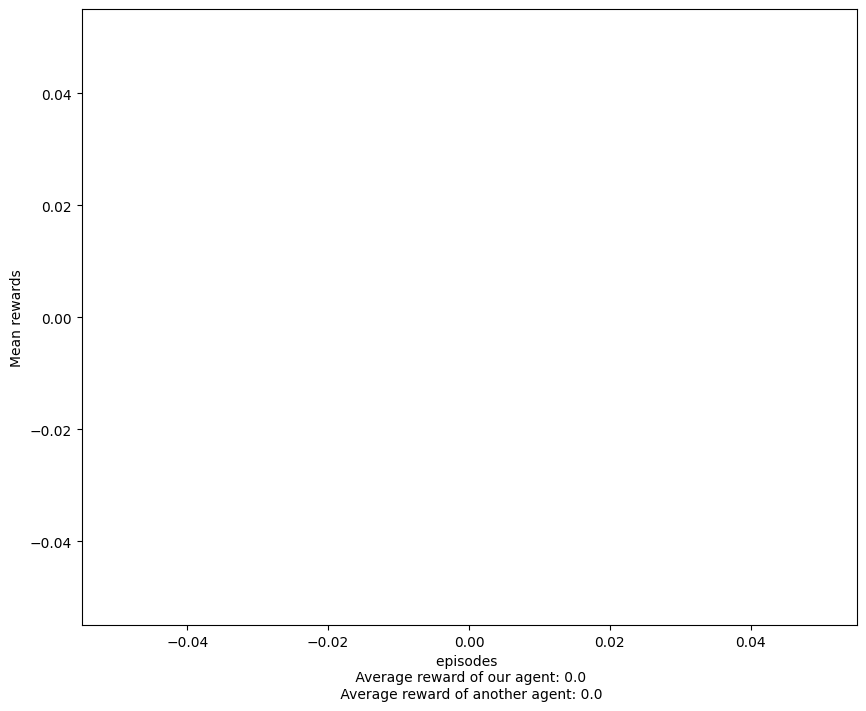

In [30]:
#generate reward mean per step of batch 0
plot_rew_mean = np.mean(plot_rew[0,:,0], axis=0)
fig_handle = plt.plot(plot_rew_mean)
#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew[:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[:,:,1])))

plt.ylabel("Mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_mp1.png'  , dpi = 100)
plt.clf()


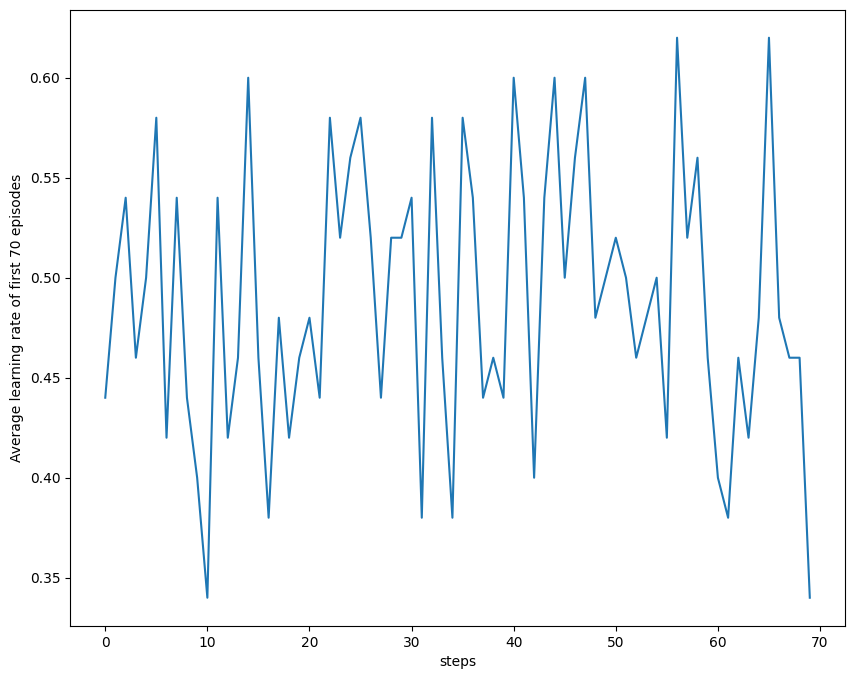

In [18]:
#generate learning curve at start
plot_rew_epi_start = np.mean(plot_rew[0, :int(meta_epi*0.1), :, 0], axis=1)
fig_handle = plt.plot(plot_rew_epi_start)

plt.xlabel("steps")

plt.ylabel("Average learning rate of first " + str(int(meta_epi*0.1)) + " episodes")

figure3 = plt.gcf() # get current figure
figure3.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_first_epi_mp1.png' , dpi = 100)
plt.clf()

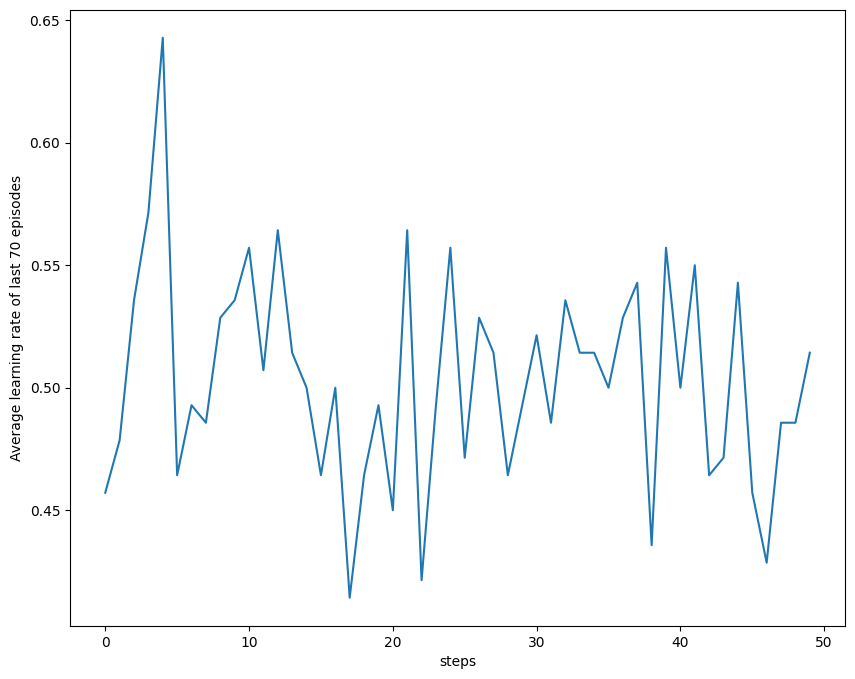

In [16]:
#generate learning curve at end
plot_rew_epi_end = np.mean(plot_rew[0, -int(meta_epi*0.1):, :, 0], axis=0)
fig_handle = plt.plot(plot_rew_epi_end)

plt.xlabel("steps")

plt.ylabel("Average learning rate of last " + str(int(meta_epi*0.1)) + " episodes")

figure4 = plt.gcf() # get current figure
figure4.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_last_epi_mp1.png' , dpi = 100)
plt.clf()

# Interpreting results 

In [4]:
import glob

path1 = "plot_rew*.pkl"
path2 = "rmax*.pkl"
        
for filename in glob.glob(path1):    
    with open(filename, 'rb') as g:
        plot_rew = pickle.load(g)
        
for filename in glob.glob(path2):    
    with open(filename, 'rb') as g:
        rmax = pickle.load(g)        